First production dense AE with SM dataset externally loaded

In [1]:
AEversion = '2'

In [2]:
import numpy as np
import os, sys, pickle
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [3]:
import gpustat
try:
    gpustat.print_gpustat()
except:
    pass

imperium-sm.hep.caltech.edu  Tue Jul  9 03:40:11 2019
[0] GeForce GTX 1080 | 21'C,   0 % |    11 /  8119 MB |
[1] GeForce GTX 1080 | 23'C,   0 % |    11 /  8119 MB |
[2] GeForce GTX 1080 | 27'C,   0 % |    10 /  8119 MB |
[3] GeForce GTX 1080 | 44'C,  11 % |  1500 /  8119 MB | ocerri(1489M)
[4] GeForce GTX 1080 | 25'C,   0 % |  1462 /  8119 MB | ocerri(1451M)
[5] GeForce GTX 1080 | 23'C,   0 % |    11 /  8119 MB |
[6] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[7] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
sys.path.append('../lib')
from progressBar import ProgressBar
from utils import EarlyStopping, createROC_curve

In [6]:
dnd = []

## Get the dataset

In [7]:
from dataLoaders import ParticleDataset

In [8]:
dataset = ParticleDataset(template='../data/20190708_50part_PtOrder_v2/{}.npy', N_part=20, N_features=5)

In [9]:
dataset.loadTrainSM(N_train_max=1e7)
dataset.charge(dataset.SMMix_train)

Fetching Wlnu
Fetching qcd
Fetching Zll
Fetching ttbar
QCD is limiting, using it for both val and split
Expected 3.38M train
Expected 3.38M val

Loading Wlnu
Reloading QCD for validation
Loading Zll
Loading ttbar
+--------+----------+-------+-------+
| Sample | Evts tot | Train |  Val  |
+--------+----------+-------+-------+
|  Wlnu  |  4000k   | 2000k | 2000k |
|  qcd   |  1166k   | 1142k | 1142k |
|  Zll   |  1000k   |  226k |  226k |
| ttbar  |  1000k   |  10k  |  10k  |
+--------+----------+-------+-------+
Tot training 3.38 M
Tot val 3.38 M


In [10]:
dataset.loadValidationSamples('BSM')

Loading Ato4l (47.7k)
Loading leptoquark (273.6k)
Loading hToTauTau (681.8k)
Loading hChToTauNu (338.5k)


## Define the model

In [11]:
class AEDenseNet(nn.Module):
    def __init__(self, N_part, N_features, dim_hidden, dim_latent, verbose = False):
        super(AEDenseNet, self).__init__()
        self.verbose = verbose
        
        self.No = N_part
        self.p = N_features
        self.Nk = dim_latent
        
        self.encoder_modules = nn.ModuleDict({
            'PhiE': self.build_dense(dim_in=self.p*self.No,
                                   dim_out=self.Nk,
                                   dim_hidden=dim_hidden)
        })
        
        
        self.decoder_modules = nn.ModuleDict({
            'PhiD': self.build_dense(dim_in=self.Nk,
                                   dim_out=self.p*self.No,
                                   dim_hidden=dim_hidden),
            'ChargeDec': self.build_dense(dim_in=2,
                                   dim_out=3),
            'pdgIdDec': self.build_dense(dim_in=2,
                                   dim_out=5)
        })
        
        
        self.onGPU = False
          
    def build_dense(self, dim_in, dim_out, dim_hidden=0):
        if dim_hidden:
            net = nn.Sequential(
                                nn.Linear(dim_in, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_out),
                              )
        else:
            d_avg = int(0.5*(dim_in + dim_out))
            net = nn.Sequential(
                                nn.Linear(dim_in, d_avg),
                                nn.ReLU(),
                                nn.Linear(d_avg, dim_out),
                              )
        return net
        
    def encode(self, x):
        z_raw = self.encoder_modules['PhiE'](x.contiguous().view(-1, self.p*self.No))
        z = F.hardtanh(z_raw, min_val=-5, max_val=5)
        return z
    
    def decode(self, z):
        x_raw = self.decoder_modules['PhiD'](z).view(-1, self.No, self.p)
        
        # --- Formatting x ----
        # pt
        pt = torch.exp(x_raw[:,:,0]).view(-1, self.No, 1)
#         pt = 1. + F.elu(x_raw[:,:,0]).view(-1, self.No, 1)
        # eta
        eta = F.hardtanh(x_raw[:,:,1], min_val=-5, max_val=5).view(-1, self.No, 1)
        # phi
        phi = torch.fmod(torch.abs(x_raw[:,:,2]), 6.2831853072).view(-1, self.No, 1) - 3.14159265359
        # charge
        charge_cat = F.softmax(self.decoder_modules['ChargeDec'](x_raw[:,:,3:].view(-1,2)), dim=1)
        charge = torch.argmax(charge_cat, dim=1).view(-1, self.No, 1) - 1.
        # pId
        pId_cat = F.softmax(self.decoder_modules['pdgIdDec'](x_raw[:,:,3:].view(-1,2)), dim=1)
        pId = torch.argmax(pId_cat, dim=1).view(-1, self.No, 1)
        
        x = torch.cat((pt,eta, phi, charge.float(), pId.float()), 2)
        return x
        
    
    def forward(self, x):
        z = self.encode(x)
        x_prime = self.decode(z)
        return x_prime
    
    def initWeights(self):
        def weights_init(M):
            if hasattr(M, 'weight'):
                nn.init.xavier_normal_(M.weight.data)
        
        self.apply(weights_init)
    
    def useGPU(self, N_GPU=1):
        if torch.cuda.is_available():
            print('Current device: {} ({} available)'.format(torch.cuda.current_device(), 
                                                             torch.cuda.device_count()))
            self.N_GPU = N_GPU
            torch.cuda.empty_cache()
            self.cuda(N_GPU)
            gpustat.print_gpustat()
            
            self.onGPU = True
        else: 
            print('GPU not available')

In [12]:
Latent_dimension = int(2*dataset.inputs.shape[1])
Hidden_dimension = int(0.5*(Latent_dimension + dataset.inputs.shape[1]*dataset.inputs.shape[2]))

model = AEDenseNet(
                   N_part=dataset.inputs.shape[1],
                   N_features=dataset.inputs.shape[2],
                   dim_hidden=Hidden_dimension,
                   dim_latent=Latent_dimension
                  )

print(model)
trainablePars = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('\nTrainable parameters:', trainablePars)

# model.initWeights()

AEDenseNet(
  (encoder_modules): ModuleDict(
    (PhiE): Sequential(
      (0): Linear(in_features=100, out_features=70, bias=True)
      (1): ReLU()
      (2): Linear(in_features=70, out_features=70, bias=True)
      (3): ReLU()
      (4): Linear(in_features=70, out_features=40, bias=True)
    )
  )
  (decoder_modules): ModuleDict(
    (ChargeDec): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2, out_features=3, bias=True)
    )
    (PhiD): Sequential(
      (0): Linear(in_features=40, out_features=70, bias=True)
      (1): ReLU()
      (2): Linear(in_features=70, out_features=70, bias=True)
      (3): ReLU()
      (4): Linear(in_features=70, out_features=100, bias=True)
    )
    (pdgIdDec): Sequential(
      (0): Linear(in_features=2, out_features=3, bias=True)
      (1): ReLU()
      (2): Linear(in_features=3, out_features=5, bias=True)
    )
  )
)

Trainable parameters: 29864


In [13]:
model.useGPU(int(AEversion))
torch.cuda.device(int(AEversion))

Current device: 0 (8 available)
imperium-sm.hep.caltech.edu  Tue Jul  9 03:40:36 2019
[0] GeForce GTX 1080 | 21'C,   0 % |    11 /  8119 MB |
[1] GeForce GTX 1080 | 23'C,   0 % |    11 /  8119 MB |
[2] GeForce GTX 1080 | 29'C,   4 % |   467 /  8119 MB | ocerri(457M)
[3] GeForce GTX 1080 | 43'C,  18 % |  1500 /  8119 MB | ocerri(1489M)
[4] GeForce GTX 1080 | 25'C,   0 % |  1462 /  8119 MB | ocerri(1451M)
[5] GeForce GTX 1080 | 23'C,   0 % |    11 /  8119 MB |
[6] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[7] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |


## Loss

In [14]:
def criterion(x_in, x_out, reduction='mean'):
    flattened_shape = x_in.shape[1]*x_in.shape[2]
    out = F.l1_loss(x_in.view(-1, flattened_shape), 
                    x_out.view(-1, flattened_shape), 
                    reduction='none'
                    )
    out_per_evt = torch.sum(out, dim=1)
    if reduction == 'mean':
        return torch.mean(out_per_evt)
    elif reduction == 'none':
        return out_per_evt
    else:
        raise

## Training

In [15]:
training_params = {'batch_size': 10000,
                   'shuffle': True,
                   'num_workers': 3
                  }

max_epochs = 200

eval_params = {'batch_size': 10000,
               'num_workers': 3
              }

In [16]:
# torch.autograd.set_detect_anomaly(True);

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.3,
                              patience=3,
                              verbose=1,
                              threshold=1e-4,
                              cooldown=2,
                              min_lr=1e-7
                             )

# Early stopping
earlyStopping = EarlyStopping(patient=10)

In [18]:
train_loss = []
BSM_eff = {'ep': []}
for n in dataset.BSM_names:
    BSM_eff[n] = []

loss_history = {'train': [], 'val': []}
optimizer.zero_grad()
for epoch in range(max_epochs):
    batch_loss = []
    
    #### ---- Training ---- ####
    model.train()
    dataset.charge(dataset.SMMix_train)
    train_data_iter = torch.utils.data.DataLoader(dataset, **training_params)
    pb = ProgressBar(len(train_data_iter), percentPrecision=5, headLabel='Epoch {}: '.format(epoch))
    for local_x, _ in train_data_iter:
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
        
        x_prime = model(local_x)        
        loss = criterion(local_x, x_prime)        
        batch_loss.append(loss.item())
        
        tail_label = 'Loss: {:2.2e}'.format(loss.item())
        if len(loss_history['train']) > 0:
            tail_label += ' ({:2.2e})'.format(loss.item() - loss_history['train'][-1][-1])
        pb.show(len(batch_loss)-1, tail_label=tail_label)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    model.eval()
    aux_loss = 0
    N_batches = 0
    for local_x, _ in train_data_iter:
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
        x_prime = model(local_x)
        loss = criterion(local_x, x_prime)
        aux_loss += loss.item()
        N_batches += 1
    batch_loss.append(aux_loss/N_batches)
    
    printout = 'Loss: {:2.2e}'.format(batch_loss[-1])
    if len(loss_history['train']) > 0:
        printout += ' - Delta: {:2.2e}'.format(batch_loss[-1] - loss_history['train'][-1][-1])
    if len(loss_history['train']) > 1:
        d2L_de2 = batch_loss[-1] - 2*loss_history['train'][-1][-1] + loss_history['train'][-2][-1]
        printout +=' - Trend: {:2.2e}'.format(d2L_de2)
    print(printout)
    
    loss_history['train'].append(batch_loss)
    
    #### ---- Validation ---- ####
    dataset.charge(dataset.SMMix_val)
    val_data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
    aux_loss = 0
    N_batches = 0
    for local_x, _ in val_data_iter:
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
        x_prime = model(local_x)
        loss = criterion(local_x, x_prime)
        aux_loss += loss.item()
        N_batches += 1
    loss_history['val'].append(aux_loss/N_batches)
    printout = 'Val Loss: {:2.2e}'.format(loss_history['val'][-1])
    print(printout)
    
    print('')
    if not earlyStopping.check(loss_history['val'][-1]):
        break

    scheduler.step(batch_loss[-1])
    
    #### ---- Anomaly Detection monitor ---- ####
    if epoch%3 == 0:
        print('-------- Anomaly Detection monitor --------')
        BSM_eff['ep'].append(epoch)
        dataset.loss['SMMix'] = np.zeros((0))
        
        pb = ProgressBar(len(val_data_iter), percentPrecision=5, headLabel='SM Mix: ')
        for i, (local_x, _) in enumerate(val_data_iter):
                pb.show(i)
                if model.onGPU:
                    local_x = local_x.cuda(model.N_GPU)
                    
                x_prime = model(local_x)
                loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
                dataset.loss['SMMix'] = np.concatenate((dataset.loss['SMMix'], loss))
        
        p_SM = np.logspace(base=10, start=-5, stop=-3, num=3)
        if not 'p_SM' in BSM_eff.keys():
            BSM_eff['p_SM'] = p_SM
        q_SM = np.quantile(dataset.loss['SMMix'], 1-p_SM)
        
        table = PrettyTable(['SM Mix'] + list(map(lambda x: '{:1.2e}'.format(x), p_SM)))
        
        for n in dataset.BSM_names:
            dataset.loss[n] = np.zeros((0))

            dataset.charge(dataset.valSamples[n])
            data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
            pb = ProgressBar(len(data_iter), percentPrecision=5, headLabel=n+': ')
            for i, (local_x, _) in enumerate(data_iter):
                pb.show(i)
                if model.onGPU:
                    local_x = local_x.cuda(model.N_GPU)

                x_prime = model(local_x)
                loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
                dataset.loss[n] = np.concatenate((dataset.loss[n], loss))
        
            out = dataset.loss[n] > np.atleast_2d(q_SM).T
            p_BSM = np.float64(np.sum(out, axis=1, dtype=np.float128)/dataset.loss[n].shape[0])
            BSM_eff[n].append(p_BSM)
            
            table.add_row([n] + list(map(lambda x: '{:1.2e}'.format(x), p_BSM)))
        print(table)                
        print('-------------------------------------------\n\n')

model.eval()
torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'.pkl');

Epoch 0: [####################]  100% - Tot. time: 18.0 s           
Loss: 8.39e+01
Val Loss: 8.39e+01

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 20.7 s
Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.3 s
hToTauTau: [####################]  100% - Tot. time: 3.6 s
hChToTauNu: [####################]  100% - Tot. time: 1.6 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 8.38e-05 | 9.85e-04 | 2.36e-02 |
| leptoquark | 8.41e-05 | 9.43e-04 | 1.36e-02 |
| hToTauTau  | 8.05e-04 | 6.30e-03 | 4.14e-02 |
| hChToTauNu | 1.44e-03 | 1.05e-02 | 5.47e-02 |
+------------+----------+----------+----------+
-------------------------------------------


Epoch 1: [####################]  100% - Tot. time: 15.7 s                       
Loss: 1.32e+02 - Delta: 4.80e+01
Val Loss: 1.32e+02

Epoch 2: [##

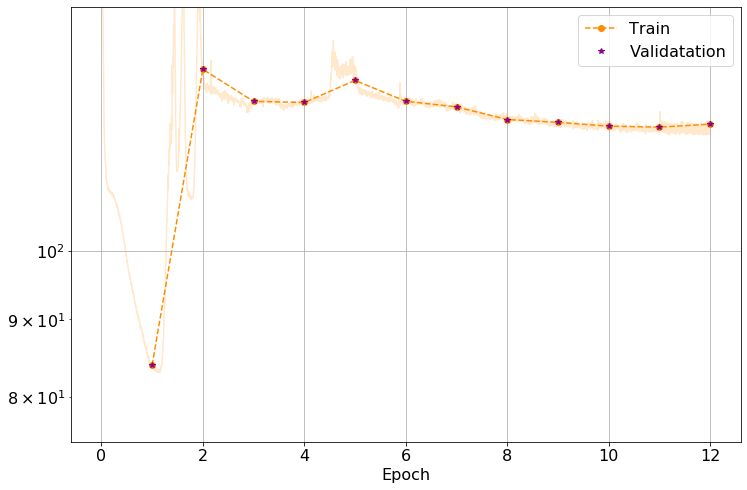

In [19]:
loss_history['train'] = np.array(loss_history['train'])
matplotlib.rcParams.update({'font.size': 16})

f = plt.figure(figsize=(12,8))

train_loss_flat = loss_history['train'].flatten()
x = np.arange(1, train_loss_flat.shape[0]+1) * float(loss_history['train'].shape[0])/train_loss_flat.shape[0]
plt.plot(x, train_loss_flat, '-', alpha=0.2, color='darkorange')

x = np.arange(1, loss_history['train'].shape[0]+1)
plt.plot(x, loss_history['train'][:,-1], 'o--', label='Train', color='darkorange')
plt.plot(x, loss_history['val'], '*', label='Validatation', color='darkmagenta')

plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')
plt.yscale('log')
plt.ylim(0.9*np.min(train_loss_flat), 1.1*np.max(loss_history['train'][1:, -1]))

f.savefig('plots/TrainingHistory_dAE_v'+AEversion+'.png')

f = open('data/TrainingHistory_dAE_v'+AEversion+'.pkl', 'wb')
pickle.dump(loss_history, f)
f.close()

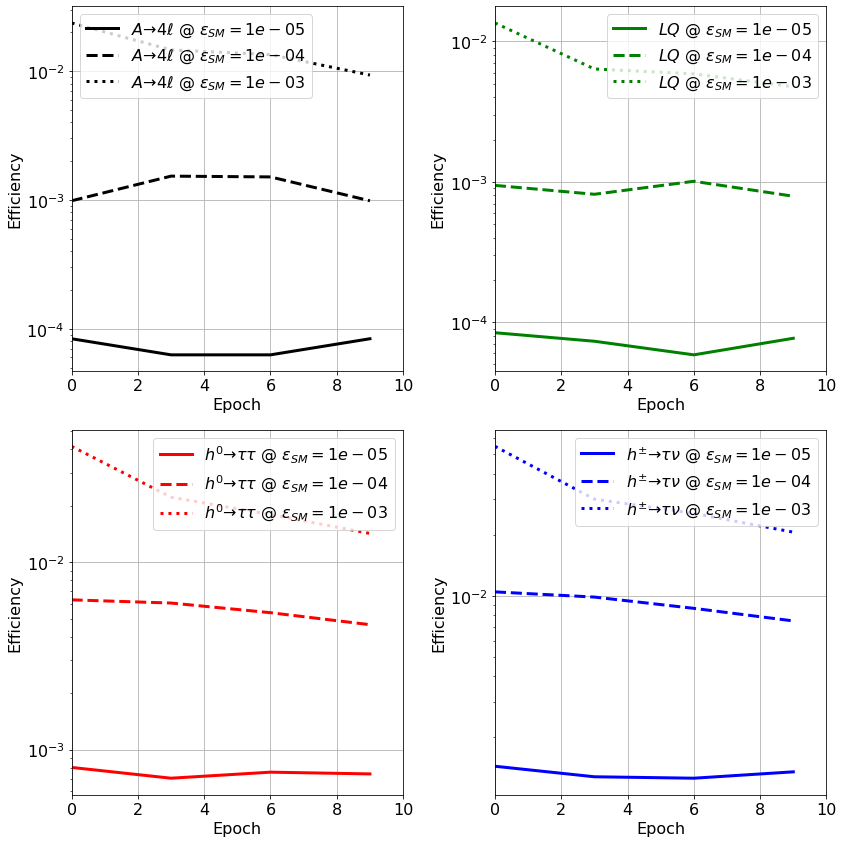

In [20]:
f, ax_arr = plt.subplots(2,2, figsize=(12,12))
styles = ['-', '--', ':']
x = BSM_eff['ep']
for i, n in enumerate(dataset.BSM_names):  
    ax = ax_arr[int(i/2),i%2]
    
    BSM_eff[n] = np.array(BSM_eff[n])
    
    for j in range(BSM_eff['p_SM'].shape[0]):
#         ax.plot(x, len(x)*[BSM_eff['p_SM'][j]], color='gray', lw=2, linestyle=styles[j])
        ax.plot(x, BSM_eff[n][:,j], 
                color=dataset.process_colors[n], lw=3, linestyle=styles[j], 
                label=dataset.process_labels[n] + ' @ $\epsilon_{{SM}} = {:1.0e}$'.format(BSM_eff['p_SM'][j]))
        
    ax.set_xlim([0, x[-1]+1])
#     ax.set_ylim([1e-6, 5])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Efficiency')
    ax.set_title('')
    ax.set_yscale('log')
    ax.grid()
    
    ax.legend(loc='best')
    
f.tight_layout()

f = open('data/AnomalyDetectionHistory_dAE_v'+AEversion+'.pkl', 'wb')
pickle.dump(BSM_eff, f)
f.close()

# Convergence check

In [21]:
dataset.charge(dataset.SMMix_val)
x = dataset.inputs
model.eval()
if model.onGPU:
    x_prime = model(torch.from_numpy(x[:10000]).cuda(model.N_GPU)).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000]).cuda(model.N_GPU)).cpu().detach().numpy()
else:
    x_prime = model(torch.from_numpy(x[:10000])).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000])).cpu().detach().numpy()

### Latent space

/nfshome/ocerri/miniconda2/envs/PartAN/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


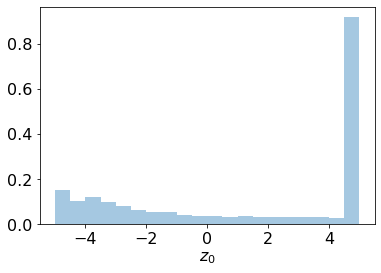

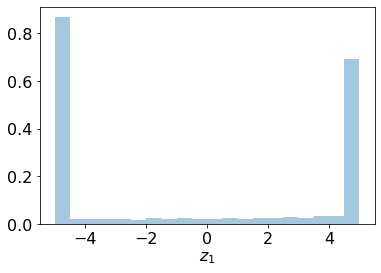

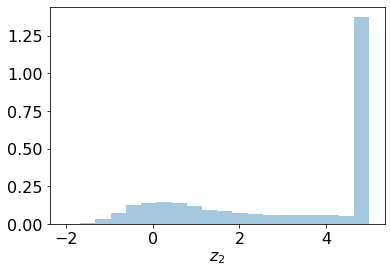

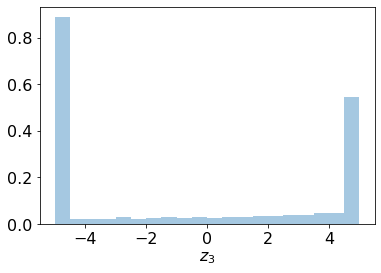

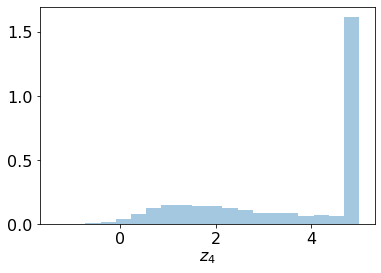

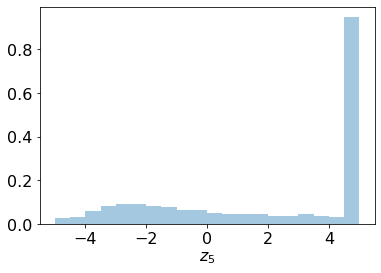

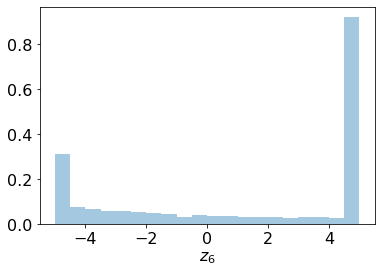

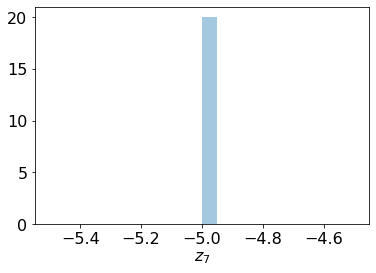

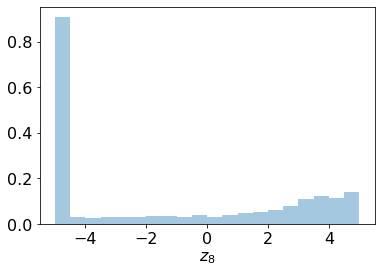

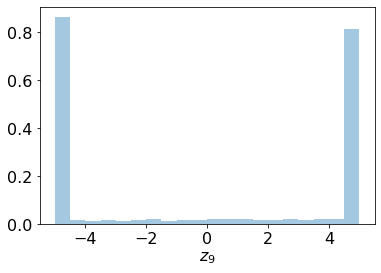

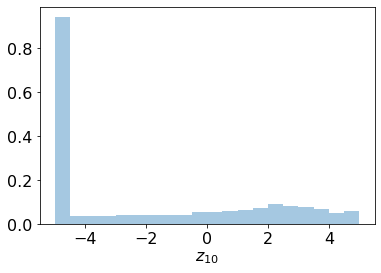

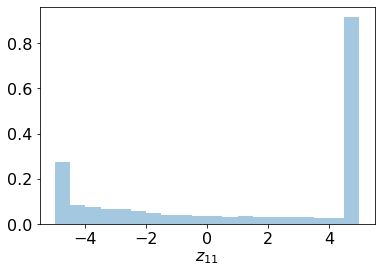

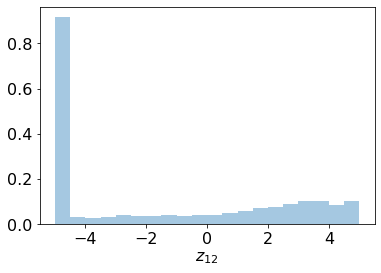

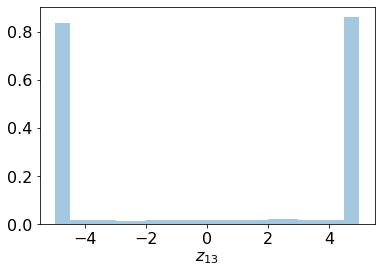

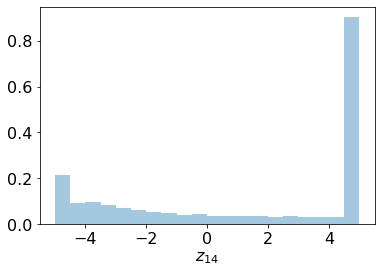

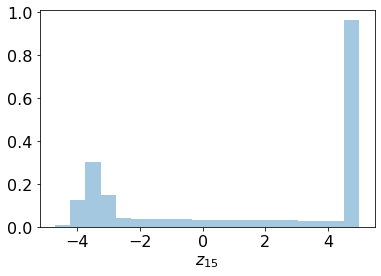

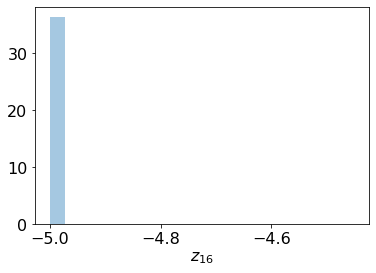

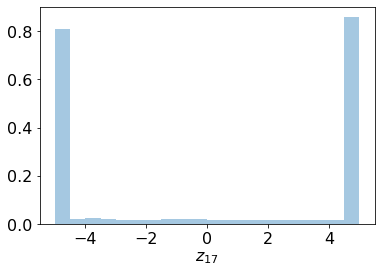

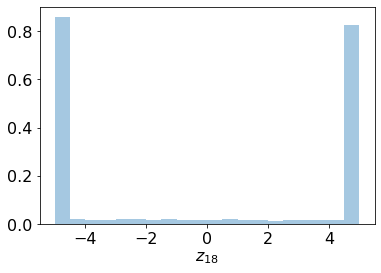

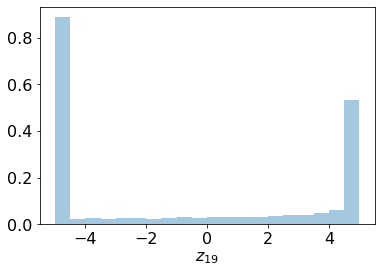

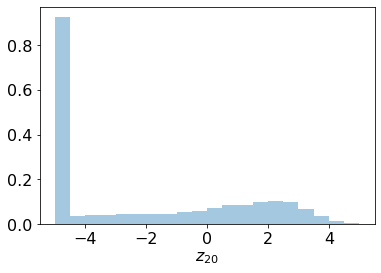

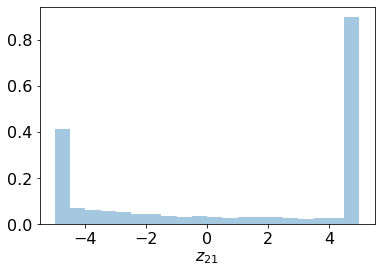

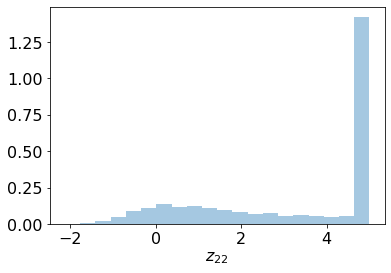

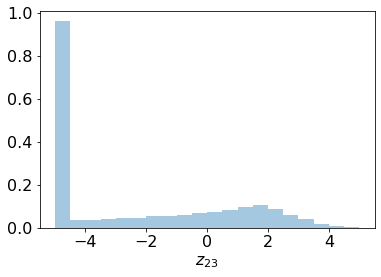

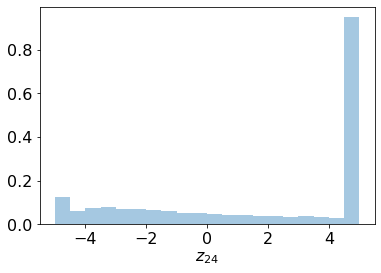

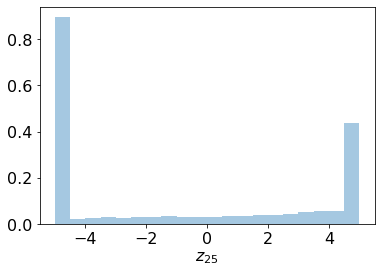

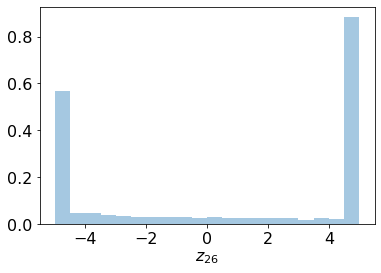

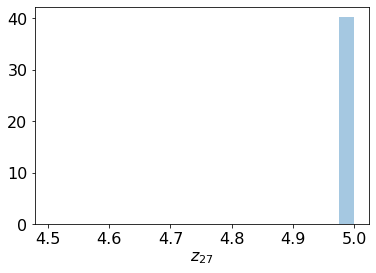

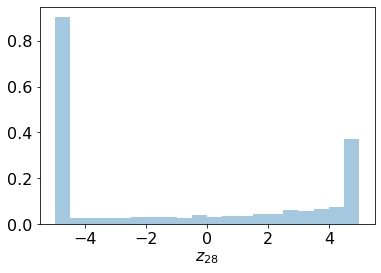

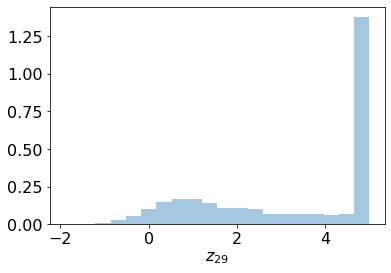

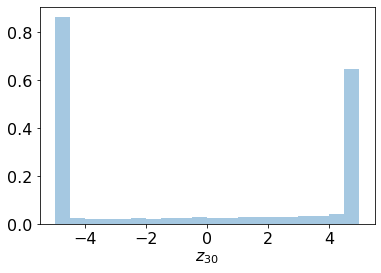

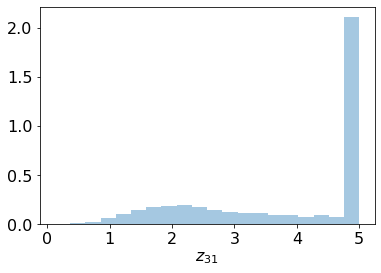

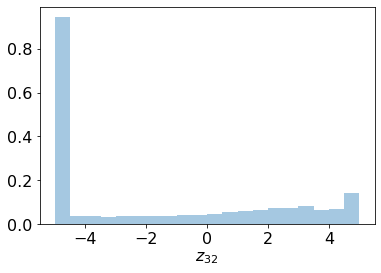

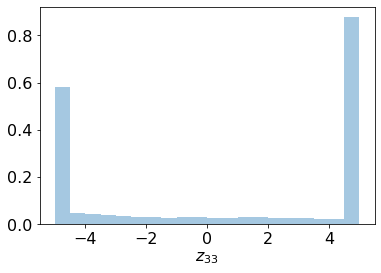

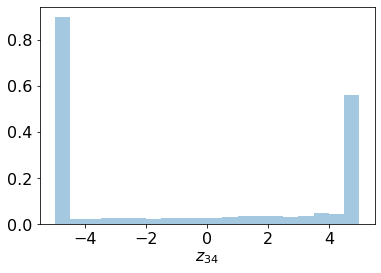

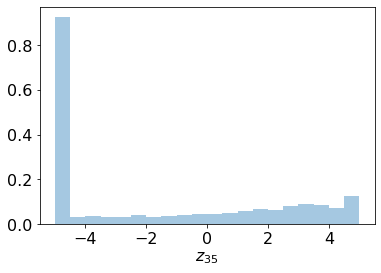

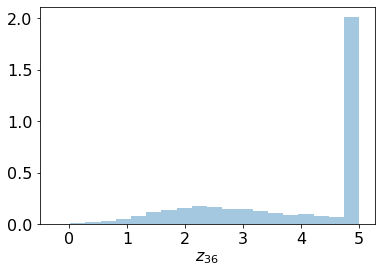

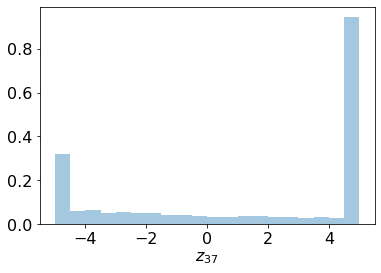

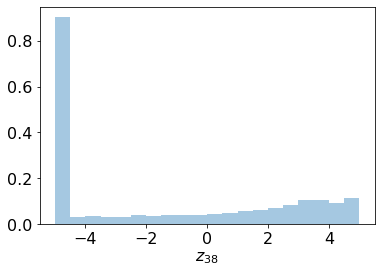

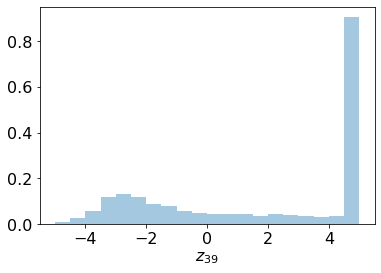

In [22]:
for i in range(z.shape[1]):
    x_aux = z[:,i]
    f = plt.figure(i)
    r = (np.min(x_aux), np.max(x_aux))
    plt.hist(x_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.xlabel('$z_{{{}}}$'.format(i))
    dnd.append(f)

### Output features

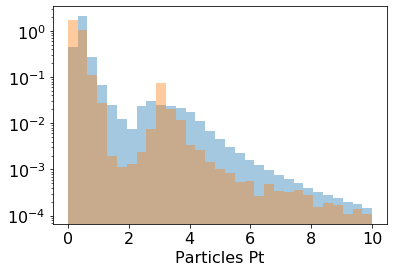

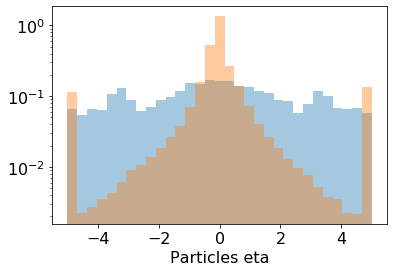

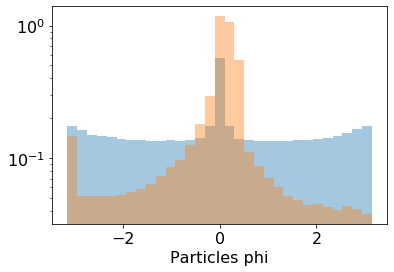

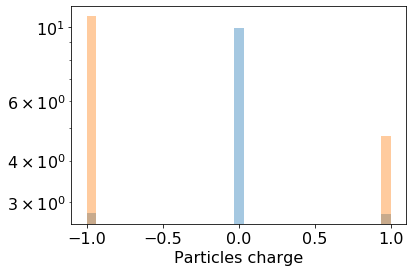

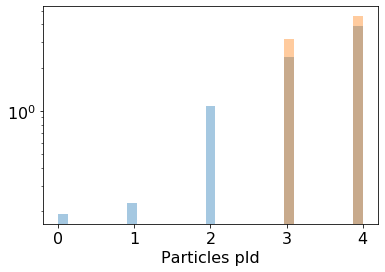

In [23]:
for i in range(x_prime.shape[2]):
    x_aux = x[:,:,i].flatten()
    xp_aux = x_prime[:,:,i].flatten()
    f = plt.figure(i)
    r = (min(np.min(x_aux), np.min(xp_aux)), max(np.max(x_aux), np.max(xp_aux)))
    if i == 0:
        r = (0,10)
    plt.hist(x_aux, bins=31, range=r, alpha=0.4, density=True)
    plt.hist(xp_aux, bins=31, range=r, alpha=0.4, density=True)
    plt.xlabel('Particles ' + dataset.feature_names[i])
    plt.yscale('log')
    dnd.append(f)

# Performance evaluation

In [24]:
dataset.loadValidationSamples('SM')

Loading Wlnu (2000.0k)
Loading qcd (1141.9k)
Loading Zll (773.6k)
Loading ttbar (989.9k)
SM Mix limiting stat. sample: qcd (1.14M)
SM validation weights
[('Wlnu', 0.99999921893491114253), ('qcd', 1.0), ('Zll', 0.29257605781977745954), ('ttbar', 0.010238898454774046649)]


In [25]:
model.eval()
for n in dataset.valSamples.keys():
    dataset.loss[n] = np.zeros((0))
    
    dataset.charge(dataset.valSamples[n])
    data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
    pb = ProgressBar(len(data_iter), percentPrecision=5, headLabel=n+': ')
    for i, (local_x, _) in enumerate(data_iter):
        pb.show(i)
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
            
        x_prime = model(local_x)
        loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
        dataset.loss[n] = np.concatenate((dataset.loss[n], loss))

Ato4l: [#####]  100% - Tot. time: 0.3 s
leptoquark: [####################]  100% - Tot. time: 1.6 s
hToTauTau: [####################]  100% - Tot. time: 5.7 s
hChToTauNu: [####################]  100% - Tot. time: 2.6 s
Wlnu: [####################]  100% - Tot. time: 17.8 s
qcd: [####################]  100% - Tot. time: 9.1 s
Zll: [####################]  100% - Tot. time: 6.3 s
ttbar: [####################]  100% - Tot. time: 8.3 s


In [26]:
dic_ROC = createROC_curve(dataset)
pickle.dump(dic_ROC, open('data/dAE_v{}_ROC_dic.pkl'.format(AEversion), 'wb'))

CumSum accuracy: 1.0000000000000023217


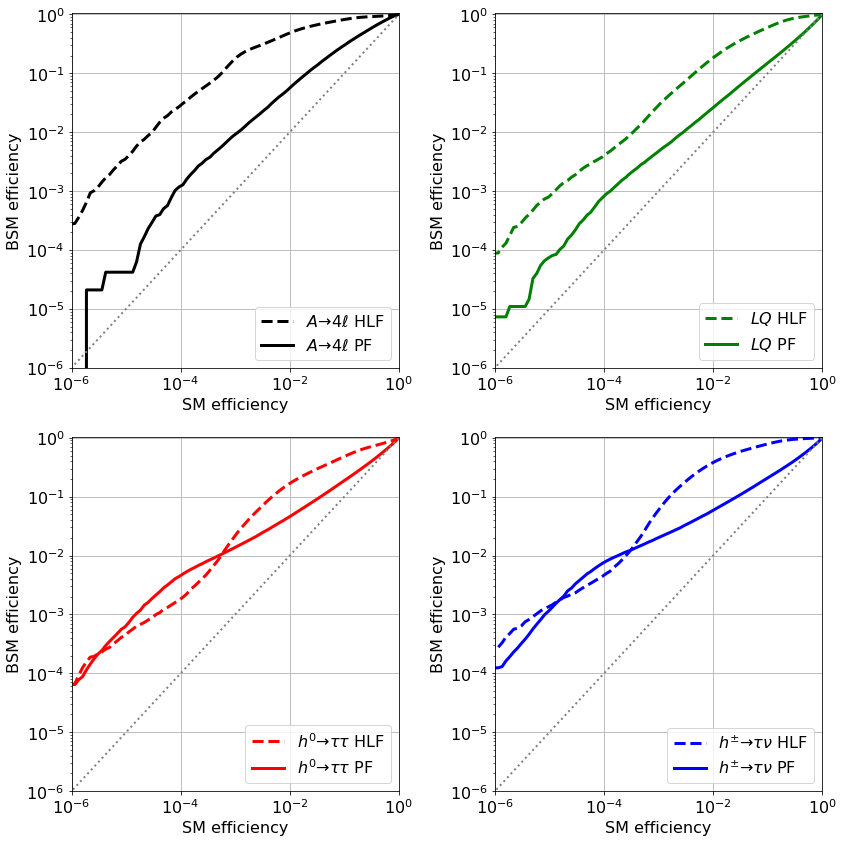

In [27]:
f_ROC, ax_arr = plt.subplots(2,2, figsize=(12,12))
for i, n in enumerate(dataset.BSM_names):
    f = open('../data/HLFref1811-10276_loss/VAE_all-in-one_v71_ROC1_dict_{}.pkl'.format(n), 'br')
    dRef = pickle.load(f, encoding='bytes')
    f.close()
    
    ax = ax_arr[int(i/2),i%2]
    ax.plot(dRef[b'eff_SM'], dRef[b'eff_BSM'], label=dataset.process_labels[n] + ' HLF',
            linestyle='--', lw=3, color=dataset.process_colors[n])
    ax.plot(dic_ROC[n]['eff_SM'], dic_ROC[n]['eff_BSM'], label=dataset.process_labels[n] + ' PF',
            linestyle='-', lw=3, color=dataset.process_colors[n])
    ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle=':')
    ax.set_xlim([1e-6, 1.0])
    ax.set_ylim([1e-6, 1.05])
    ax.set_xlabel('SM efficiency')
    ax.set_ylabel('BSM efficiency')
    ax.set_title('')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid()
    
    ax.legend(loc='lower right')
    
f_ROC.tight_layout()

## Latent dimension clustering

In [28]:
from sklearn.manifold import TSNE

In [32]:
dataset.encoded = {}

for n in dataset.BSM_names:    
    dataset.charge(dataset.valSamples[n][:10000])
    x_in = torch.Tensor(dataset.inputs)
    if model.onGPU:
        x_in = x_in.cuda(model.N_GPU)
    dataset.encoded[n] = model.encode(x_in).cpu().detach().numpy()
    
dataset.charge(dataset.SMMix_val[:10000])
x_in = torch.Tensor(dataset.inputs)
if model.onGPU:
        x_in = x_in.cuda(model.N_GPU)
dataset.encoded['SMMix'] = model.encode(x_in).cpu().detach().numpy()

In [33]:
idx_max = 1000 #np.min(list(map(lambda x: x.shape[0], dataset.encoded.values())))
z_dset = np.zeros((0, model.Nk))

for n in dataset.encoded.keys():
    z_dset = np.concatenate((z_dset, dataset.encoded[n][:idx_max]))
    
z_embedded = TSNE(n_components=2).fit_transform(z_dset)

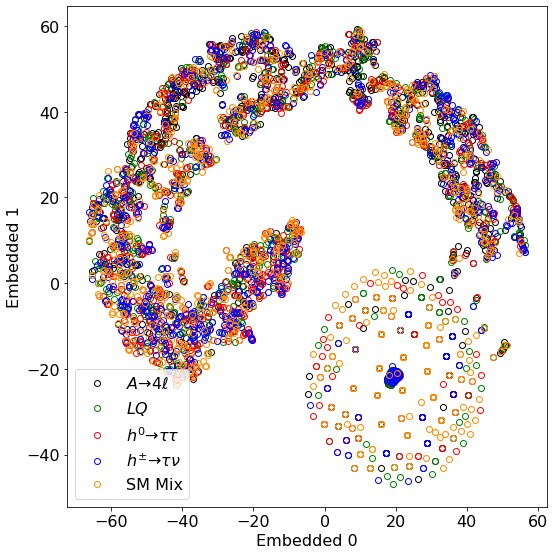

In [34]:
f = plt.figure(figsize=(8,8))

for i, n in enumerate(dataset.encoded.keys()):
    aux_z = z_embedded[i*idx_max: (i+1)*idx_max]
    plt.plot(aux_z[:,0], aux_z[:,1], 
             'o',
             color=dataset.process_colors[n], 
             mfc='none',
             label=dataset.process_labels[n])
    
plt.xlabel('Embedded 0')
plt.ylabel('Embedded 1')
plt.legend(loc='best')
f.tight_layout()